# Robust Regression

The following figure shows 42 points: 

$$ (t_i, y_i) $$ 

This points are in a plane, with two obvious outliers (one at the upper left, and one at lower right). The dashed line shows the least-squares approximation of the points by a straight line:

$$f(t) = \alpha + \beta t$$

The coefficients alpha and beta are obtained by solving the least squares problem:

$$ minimize \hspace{0.1cm} \sum_{i=1}^{42} (y_i - \alpha - \beta t_i)^2 $$

<img src="https://drive.google.com/uc?export=view&id=1RuqQl0PyhG57gN1vEPyxCXiTzNsw6jC1" width="600" align="center"/>

The least-squares approximation is clearly rotated away from the main locus of the points, toward the two outliers.

The solid line shows the robust least-squares approximation, obtained by minimizing the Huber penalty function:

$$ minimize \hspace{0.1cm} \sum_{i=1}^{42} \phi_{hub} (y_i - \alpha - \beta t_i) $$

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


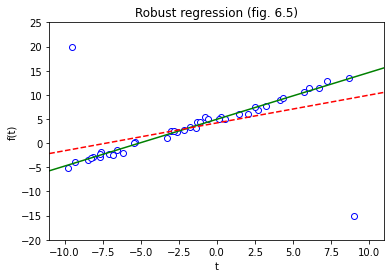

In [ ]:
# Figure 6.5, page 300.
# Robust regression.

from cvxopt import solvers, lapack, matrix, spmatrix
from pickle import load
solvers.options['show_progress'] = 0

data = load(open("/content/drive/MyDrive/Optimizacion_Convexa/03_Applications_to_modelling/Robust_Regression/huber.bin",'rb'))
u, v = data['u'], data['v']
m, n = len(u), 2

A = matrix( [m*[1.0], [u]] )
b = +v

# Least squares solution.
xls = +b
lapack.gels(+A, xls)
xls = xls[:2]


# Robust least squares.
#
# minimize  sum( h( A*x-b ))
#
# where h(u) = u^2           if |u| <= 1.0
#            = 2*(|u| - 1.0) if |u| > 1.0.
#
# Solve as a QP (see exercise 4.5):
#
# minimize    (1/2) * u'*u + 1'*v
# subject to  -u - v <= A*x-b <= u + v
#             0 <= u <= 1
#             v >= 0
#
# Variables  x (n), u (m), v(m)

novars = n+2*m
P = spmatrix([],[],[], (novars, novars))
P[n:n+m,n:n+m] = spmatrix(1.0, range(m), range(m))
q = matrix(0.0, (novars,1))
q[-m:] = 1.0

G = spmatrix([], [], [], (5*m, novars))
h = matrix(0.0, (5*m,1))

# A*x - b <= u+v
G[:m,:n] = A
G[:m,n:n+m] = spmatrix(-1.0, range(m), range(m))
G[:m,n+m:] = spmatrix(-1.0, range(m), range(m))
h[:m] = b

# -u - v <= A*x - b
G[m:2*m,:n] = -A
G[m:2*m,n:n+m] = spmatrix(-1.0, range(m), range(m))
G[m:2*m,n+m:] = spmatrix(-1.0, range(m), range(m))
h[m:2*m] = -b

# u >= 0
G[2*m:3*m,n:n+m] = spmatrix(-1.0, range(m), range(m))

# u <= 1
G[3*m:4*m,n:n+m] = spmatrix(1.0, range(m), range(m))
h[3*m:4*m] = 1.0

# v >= 0
G[4*m:,n+m:] = spmatrix(-1.0, range(m), range(m))

xh = solvers.qp(P, q, G, h)['x'][:n]

try: import pylab
except ImportError: pass
else:
    pylab.figure(1,facecolor='w')
    pylab.plot(u, v,'o',
        [-11,11], [xh[0]-11*xh[1], xh[0]+11*xh[1]], '-g',
        [-11,11], [xls[0]-11*xls[1], xls[0]+11*xls[1]], '--r',
        markerfacecolor='w', markeredgecolor='b')
    pylab.axis([-11, 11, -20, 25])
    pylab.xlabel('t')
    pylab.ylabel('f(t)')
    pylab.title('Robust regression (fig. 6.5)')
    pylab.show()